# 1. Setup

In [1]:
#@title Install required packages. { form-width: "320px" }
!pip install torch

import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

#!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
1.11.0+cu113


In [2]:
#@title Import dependencies { form-width: "320px" }
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.utils.convert import from_networkx, to_networkx
from torch_geometric.utils import to_dense_adj
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn

# 2. Handling Plumbing Graphs
Let us define some functions to deal with plumbing graphs.

In [3]:
#@title A Function to create a graph from numpy dense arrays { form-width: "320px" }
def create_graph(x, a, y = None):
    # Create a graph as a `Data` object implemented in PyG (Pytorch Geometric) from node features `x` and
    # adjacency matrix `a`.
    # `x` and `a` are supposed to be dense numpy arrays.
    pyg_graph = Data()
    nx_graph = nx.from_numpy_matrix(a) # create a 'networkx' graph from a dense adjacency matrix 'a'
    pyg_graph = from_networkx(nx_graph) # convert a networkx graph into a pyg graph 
    pyg_graph.weight = None
    pyg_graph.x = torch.tensor(x.reshape(-1, 1), dtype = torch.float32) # feeding node features
    #pyg_graph.y = y # feeding labels
    return pyg_graph

In [4]:
#@title A Fuction for Neumann moves { form-width: "320px" }
def neumann_move(g_graph, neuman_move_type = np.random.randint(1,4)):
    # This function returns a graph obtained by applying a Neumann move to the input graph `g_graph`.
    # `g_graph` is an instance of `Data` object.
    # `neuman_move_type` denotes the type of Neumann move to be applied. Its values are integers from 1 to 3.
    # The default value of `neuman_move_type` is a random integer from 1 to 3.

    # Step 1: Get node features and adjacency matrix as numpy dense arrays.
    node_label = g_graph.x.numpy()
    node_label = node_label.flatten()
    #graph_y = g_graph.y
    n = len(node_label)
    if n == 1:
        adjacency = np.zeros((1,1))
    else:
        adjacency = to_dense_adj(g_graph.edge_index)
        adjacency = adjacency.numpy()[0, :, :]

    # Step 2: Randomly choose a vertex to which a Neumann move will be applied, and find vertices directly connected to
    #         the chosen vertex
    chosen_vertex = np.random.randint(0, n)
    linked_vs=[]
    for j in range(n):
        if adjacency[chosen_vertex, j] == 1:
            linked_vs = np.append(linked_vs, j)
    linked_vs = np.array(linked_vs, dtype=int)

    sign = 1 if np.random.random() < 0.5 else -1 # Sign for Neumann moves of types 1 and 2

    # If a graph consists of single vertex, then the available types of Neumann moves are 2 and 3.
    if len(linked_vs) == 0:
        neuman_move_type = 2 if np.random.random() < 0.5 else 3
    
    # Step 3: Apply Neumann moves to the chosen vertex
    if neuman_move_type == 1:
        chosen_linked_vertex = linked_vs[np.random.randint(0, len(linked_vs))]
        node_label = np.append(node_label, sign)
        node_label[chosen_vertex] = node_label[chosen_vertex] + sign
        node_label[chosen_linked_vertex] = node_label[chosen_linked_vertex] + sign
        adjacency = np.append(adjacency, np.zeros((n, 1)), axis = 1)
        adjacency[chosen_vertex, n] = adjacency[chosen_linked_vertex, n ] = 1
        adjacency = np.append(adjacency, np.zeros((1, n + 1)), axis = 0)
        adjacency[n, chosen_vertex] = adjacency[n, chosen_linked_vertex] = 1
        adjacency[chosen_vertex, chosen_linked_vertex] = adjacency[chosen_linked_vertex, chosen_vertex] = 0
    elif neuman_move_type == 2:
        node_label = np.append(node_label, sign)
        node_label[chosen_vertex] = node_label[chosen_vertex] + sign
        adjacency = np.append(adjacency, np.zeros((n, 1)), axis = 1)
        adjacency[chosen_vertex, n] = 1
        adjacency = np.append(adjacency, np.zeros((1, n + 1)), axis = 0)
        adjacency[n, chosen_vertex] = 1        
    elif neuman_move_type == 3:
        node_label = np.append(node_label, 0)
        node_diff = np.random.randint(-20, 20)
        node_label = np.append(node_label, node_diff)
        node_label[chosen_vertex] = node_label[chosen_vertex] - node_diff
        adjacency = np.append(adjacency, np.zeros((n, 1)), axis = 1)
        adjacency = np.append(adjacency, np.zeros((1, n + 1)), axis = 0)
        adjacency = np.append(adjacency, np.zeros((n + 1, 1)), axis = 1)
        adjacency = np.append(adjacency, np.zeros((1, n + 2)), axis = 0)
        adjacency[chosen_vertex, n] = adjacency[n, chosen_vertex] = 1
        adjacency[n, n + 1] = adjacency[n + 1, n] = 1
        if len(linked_vs) > 0:
            np.random.shuffle(linked_vs)
            n_split = np.random.randint(0, len(linked_vs))
            if n_split != 0 or n_split != len(linked_vs)-1:
                linked_chosen_2 = linked_vs[n_split:]
                for i in linked_chosen_2:
                    adjacency[chosen_vertex, i] = adjacency[i, chosen_vertex] = 0
                    adjacency[n + 1, i] = adjacency[i, n + 1] = 1
    # Output
    node_label = node_label.reshape(-1, 1)
    return create_graph(node_label, adjacency)

In [5]:
#@title A Function to Plot a Graph { form-width: "320px" }
def plot_graph(pyg_graph):
    # First convert a PyG graph to a `networkx` graph, then plot the graph by using `nx.draw` function.
    # Config 
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    g = to_networkx(pyg_graph, to_undirected=True) #convert to networkx graph

    labeldict = {} # node labels in the plot
    for i in range(pyg_graph.num_nodes):
        labeldict[i]=pyg_graph.x[i].item()
    # Plot
    pos_nodes = nx.kamada_kawai_layout(g)
    pos_attrs = {}
    for node, coords in pos_nodes.items():
        pos_attrs[node] = (coords[0], coords[1] + 0.08)
    nx.draw(g, pos_nodes, node_color='black', node_size=30)
    nx.draw_networkx_labels(g, pos_attrs, labels=labeldict)
    plt.show()

In [6]:
#@title Creating a random Graph { form-width: "320px" }
def random_graph():
    # Returns a random graph (plumbing TREE) as an instance of `Data` object of PyG.
    # `n` : number of nodes, a random integer from 1 to 14
    # `x` : node features, an numpy array of random integers from -10 to 9
    # `a` : adjacency matrix
    n = np.random.randint(1, 15)
    x = np.random.randint(-10, 10, size = n)
    a=np.zeros((n, n))
    for i in range(1,n):
        j=np.random.randint(i)
        a[i,j]=a[j,i]=1
    return create_graph(x, a)

As an example, we are trying to create a random graph by using `random_graph()` function and plot it by the function named `plot_graph()`.

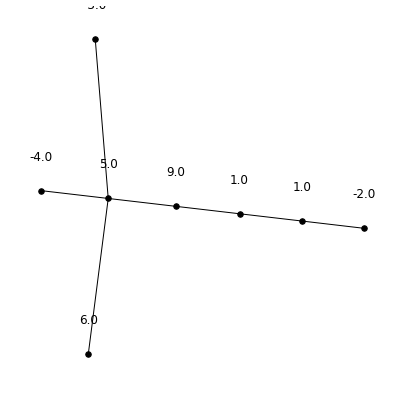

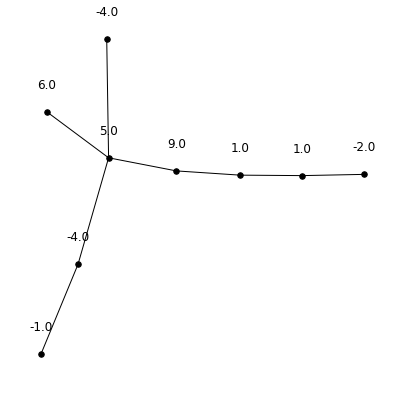

Data(edge_index=[2, 16], num_nodes=9, x=[9, 1])


In [7]:
#@title An Example { form-width: "320px" }
g_graph = random_graph()
plot_graph(g_graph)
g1_graph = neumann_move(g_graph)
plot_graph(g1_graph)
print(g1_graph)

# 3. Preparing Datasets

In [8]:
#@title Defining PairData as a subclass of Data for storing two graphs { form-width: "320px" }
class PairData(Data):
    def __init__(self, edge_index_s=None, x_s=None, edge_index_t=None, x_t=None, y = None):
        super().__init__()
        self.edge_index_s = edge_index_s
        self.x_s = x_s
        self.edge_index_t = edge_index_t
        self.x_t = x_t
        self.y = y
    def __inc__(self, key, value, *args, **kwargs):
        if key == 'edge_index_s':
            return self.x_s.size(0)
        if key == 'edge_index_t':
            return self.x_t.size(0)
        else:
            return super().__inc__(key, value, *args, **kwargs)

In [9]:
#@title Generate a random dataset { form-width: "320px" }
def generate_dataset(n_pairs = 50, n_moves = 11):
    data_list = []
    
    for j in range(0, n_pairs):
      pos = 1 if np.random.random() < 0.5 else -1
      g1 = random_graph()
      #for i in range(np.random.randint(1,n_moves)):
      #  g1 = neumann_move(g1)
      if pos == 1:
        g2 = g1
        for i in range(np.random.randint(1, n_moves)):
          g1 = neumann_move(g1)
        for i in range(np.random.randint(1, n_moves)):
          g2 = neumann_move(g2)
      else:
        g2 = random_graph()
        for i in range(np.random.randint(1, n_moves)):
          g1 = neumann_move(g1)
        for i in range(np.random.randint(1, n_moves)):
          g2 = neumann_move(g2)
      #y = torch.tensor([pos]).unsqueeze(1)
      if pos == 1:
        y = torch.tensor([pos])
      else:
        y = torch.tensor([0])
      
      # Normalize
      g1.x = F.normalize(g1.x, p = 2, dim = 0)
      g2.x = F.normalize(g2.x, p = 2, dim = 0)

      # Save
      data_list.append(PairData(g1.edge_index, g1.x, g2.edge_index, g2.x, y))
    return data_list

In [10]:
#@title Create Sets for training and testing { form-width: "320px" }

dataset = generate_dataset(n_pairs = 8000, n_moves = 2)
data_size = len(dataset)
train_loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=32, shuffle=True, follow_batch=['x_s', 'x_t'])
test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=32, shuffle=True, follow_batch=['x_s', 'x_t'])

In [11]:
average_nodes = int(sum(g_pair.x_s.size(0)+g_pair.x_t.size(0) for g_pair in dataset)/len(dataset))

# 4. Several Models and Testing

## 4.2 Model (2) - GCNConv Layers

In [12]:
#@title Making 'GCN' model with GCNConv layers { form-width: "320px" }
from torch_geometric.nn import DenseGraphConv, GCNConv, dense_mincut_pool, global_mean_pool
from torch_geometric.utils import to_dense_adj, to_dense_batch
from math import ceil

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)

        self.conv1 = GCNConv(1, hidden_channels)
        num_nodes = ceil(0.75 * average_nodes)
        self.pool1 = nn.Linear(hidden_channels, num_nodes)
        
        self.conv2 = DenseGraphConv(hidden_channels, hidden_channels)
        num_nodes = ceil(0.75 * num_nodes)
        self.pool2 = nn.Linear(hidden_channels, num_nodes)

        self.conv3 = DenseGraphConv(hidden_channels, hidden_channels)
        
        self.lin1 = nn.Linear(2*hidden_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, 2)

    def forward(self, data):
        # 1. Obtain node embeddings for x_s
        x_s = self.conv1(data.x_s, data.edge_index_s)
        x_s = x_s.relu()

        x_s, mask = to_dense_batch(x_s, data.x_s_batch)
        a_s = to_dense_adj(data.edge_index_s, data.x_s_batch)
        
        s = self.pool1(x_s)
        x_s, a_s, mc1, o1 = dense_mincut_pool(x_s, a_s, s, mask)
        
        x_s = self.conv2(x_s, a_s)
        x_s = x_s.relu()
        s = self.pool2(x_s)
        x_s, a_s, mc2, o2 = dense_mincut_pool(x_s, a_s, s)

        x_s = self.conv3(x_s, a_s)

        # 2. Obtain node embeddings for x_t
        x_t = self.conv1(data.x_t, data.edge_index_t)
        x_t = x_t.relu()

        x_t, mask = to_dense_batch(x_t, data.x_t_batch)
        a_t = to_dense_adj(data.edge_index_t, data.x_t_batch)
        
        s = self.pool1(x_t)
        x_t, a_t, mc3, o3 = dense_mincut_pool(x_t, a_t, s, mask)
        
        x_t = self.conv2(x_t, a_t)
        x_t = x_t.relu()
        s = self.pool2(x_t)
        x_t, a_t, mc4, o4 = dense_mincut_pool(x_t, a_t, s)

        x_t = self.conv3(x_t, a_t)

        # 3. Readout layer
        x_s = x_s.mean(dim = 1)
        x_t = x_t.mean(dim = 1)
        x = torch.cat((x_s, x_t), dim = 1)

        # 4. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin1(x).relu()
        x = self.lin2(x)
        
        return x, mc1 + mc2 + mc3 + mc4, o1 + o2 + o3 + o4

model_2 = GCN(hidden_channels=32)
print(model_2)

GCN(
  (conv1): GCNConv(1, 32)
  (pool1): Linear(in_features=32, out_features=13, bias=True)
  (conv2): DenseGraphConv(32, 32)
  (pool2): Linear(in_features=32, out_features=10, bias=True)
  (conv3): DenseGraphConv(32, 32)
  (lin1): Linear(in_features=64, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=2, bias=True)
)


In [13]:
#@title Train and Test Functions { form-width: "320px" }
def train():
    model.train()
    
    for data in train_loader:  # Iterate in batches over the training dataset.
         optimizer.zero_grad()
         x, mc_loss, o_loss = model(data)  # Perform a single forward pass.
         loss = criterion(x, data.y) + mc_loss + o_loss  # Compute the loss.
         
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         #optimizer.zero_grad()  # Clear gradients.

def test(loader):
  model.eval()
  correct = 0
  #loss = 0
  for data in loader:  # Iterate in batches over the training/test dataset.
      out, _, _ = model(data)  
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct += int((pred == data.y).sum())  # Check against ground-truth labels.
  return correct / len(loader.dataset)  # Derive ratio of correct predictions.

Results from GCN model with GCNConv Layers
Epoch: 001, Train Acc: 0.5002, Test Acc: 0.5006
Epoch: 010, Train Acc: 0.8736, Test Acc: 0.8788
Epoch: 020, Train Acc: 0.8728, Test Acc: 0.8806
Epoch: 030, Train Acc: 0.8781, Test Acc: 0.8862
Epoch: 040, Train Acc: 0.8878, Test Acc: 0.8919
Epoch: 050, Train Acc: 0.8770, Test Acc: 0.8800
Epoch: 060, Train Acc: 0.8791, Test Acc: 0.8869
Epoch: 070, Train Acc: 0.8778, Test Acc: 0.8775
Epoch: 080, Train Acc: 0.8942, Test Acc: 0.9012
Epoch: 090, Train Acc: 0.8755, Test Acc: 0.8781
Epoch: 100, Train Acc: 0.8834, Test Acc: 0.8906
Train Accuracy:
    Minimum  0.4998 
    Maximum  0.8950 
Test Accuracy:
    Minimum  0.4994 
    Maximum  0.9019 


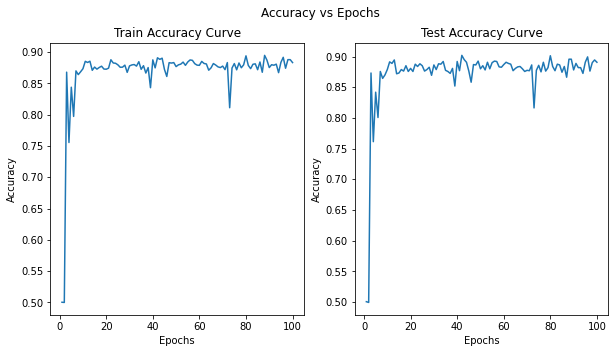

In [14]:
#@title Test Model-2 { form-width: "320px" }
model = model_2
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
train_acc = []
test_acc = []
print('Results from GCN model with GCNConv Layers')
print('===========================================')
for epoch in range(1, 101):
    train()
    trainx = test(train_loader)
    testx = test(test_loader)
    train_acc.append(trainx)
    test_acc.append(testx)
    if epoch == 1 or epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Train Acc: {trainx:.4f}, Test Acc: {testx:.4f}')
print('===========================================')
print('Train Accuracy:')
print(f'    Minimum {np.min(train_acc) : .4f} \n    Maximum {np.max(train_acc) : .4f} ')
print('Test Accuracy:')
print(f'    Minimum {np.min(test_acc) : .4f} \n    Maximum {np.max(test_acc) : .4f} ')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Accuracy vs Epochs')

epoch = range(1, 101)
ax1.plot(epoch, train_acc)
ax1.set_xlabel('Epochs')  # Add an x-label to the axes.
ax1.set_ylabel('Accuracy')  # Add a y-label to the axes.
ax1.set_title("Train Accuracy Curve")  # Add a title to the axes.

ax2.plot(epoch, test_acc)
ax2.set_xlabel('Epochs')  # Add an x-label to the axes.
ax2.set_ylabel('Accuracy')  # Add a y-label to the axes.
ax2.set_title("Test Accuracy Curve")  # Add a title to the axes.
plt.show()

In [17]:
final_test_dataset = generate_dataset(n_pairs = 1000, n_moves = 5)
final_test_loader = DataLoader(final_test_dataset, batch_size=32, shuffle=True, follow_batch=['x_s', 'x_t'])

In [18]:
test(final_test_loader)

0.742